Cargando dataset MNIST desde Keras/TensorFlow...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Dataset: MNIST (Cargado con Keras)
Shape X: (70000, 784) | Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
-----------------------------


C:\Users\ferna\AppData\Local\Temp\ipykernel_26476\1289580961.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)


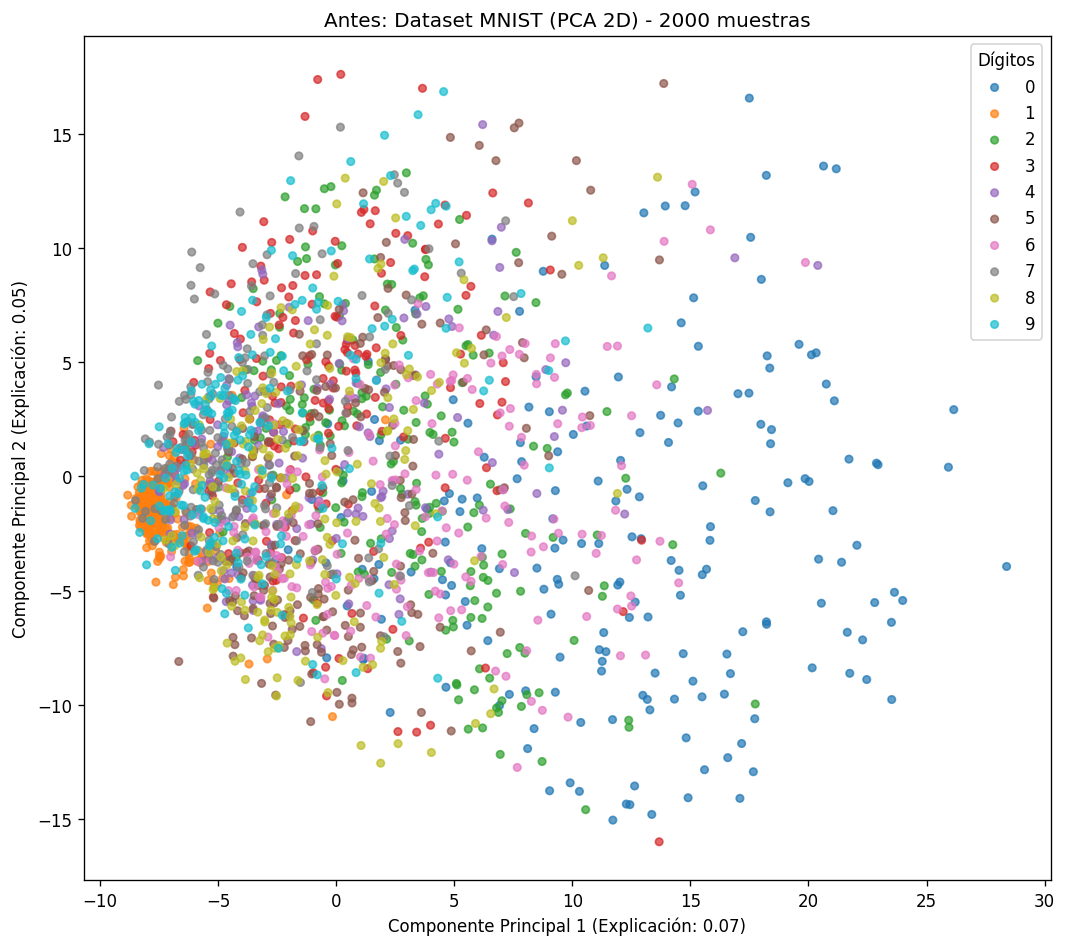


Entrenando GaussianNB en el dataset MNIST completo (esto puede tardar)...

=== GaussianNB: Métricas (macro) ===
Accuracy:  0.5227
Precision: 0.6605
Recall:    0.5148
F1-score:  0.4691

=== GaussianNB: Reporte por clase ===
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1726
           1       0.82      0.94      0.87      1969
           2       0.86      0.23      0.37      1748
           3       0.70      0.28      0.40      1785
           4       0.80      0.09      0.17      1706
           5       0.47      0.03      0.06      1578
           6       0.69      0.91      0.79      1719
           7       0.91      0.23      0.37      1823
           8       0.25      0.66      0.36      1706
           9       0.36      0.95      0.52      1740

    accuracy                           0.52     17500
   macro avg       0.66      0.51      0.47     17500
weighted avg       0.67      0.52      0.48     17500



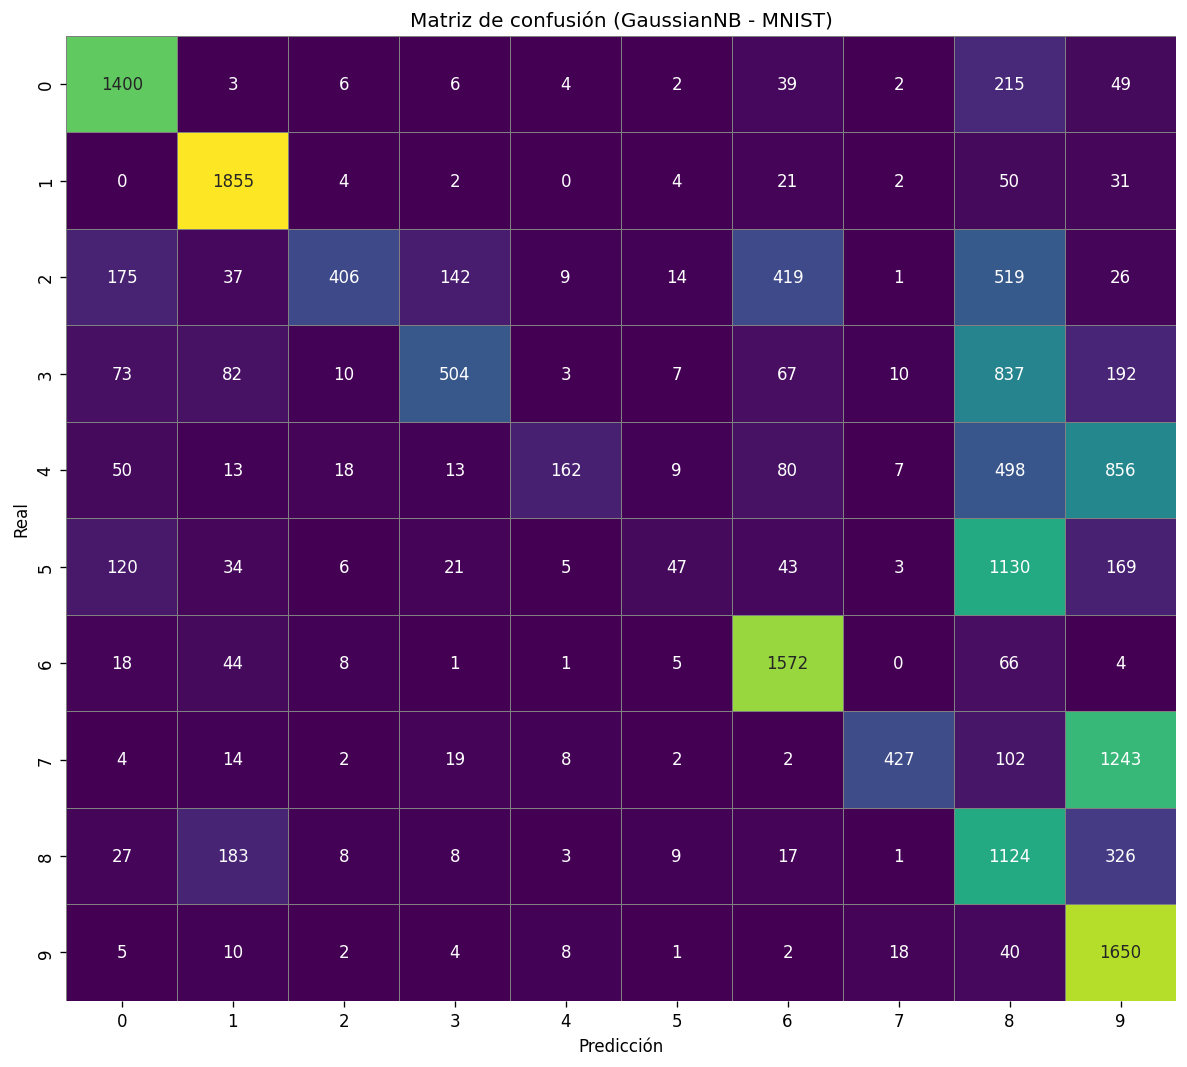

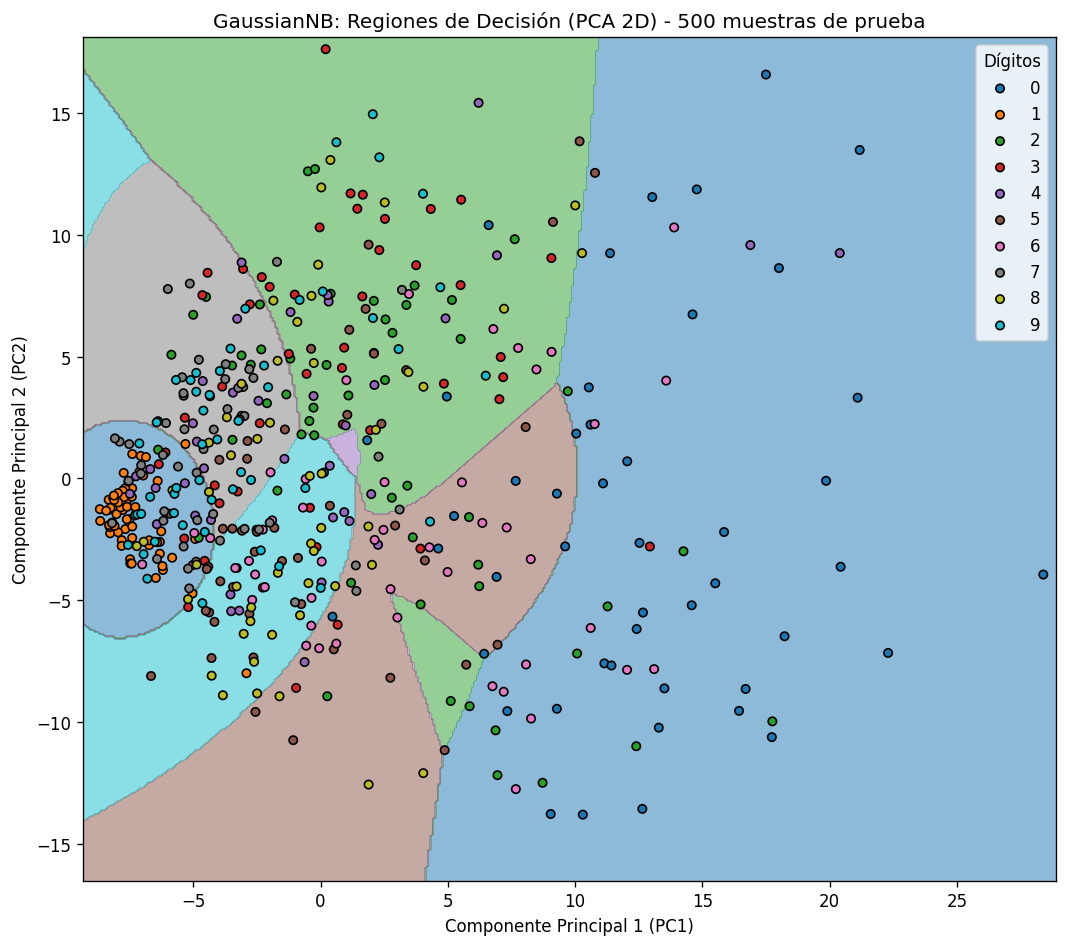

In [6]:
# ==========================================================
# === MNIST + GaussianNB ===
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import seaborn as sns 
import tensorflow as tf # Importado para la carga de datos

# from sklearn.datasets import fetch_openml # <--- COMENTADO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42

# --- Parámetros adicionales para MNIST ---
# Para el dataset completo (para métricas y entrenamiento)
N_SAMPLES_FULL = 70000 
# Para las visualizaciones de PCA y regiones de decisión
N_SAMPLES_VIZ = 2000 # Solo usaremos 2000 muestras para las gráficas

# -----------------------------
# 1) Cargar y Preparar Dataset (MNIST) - USANDO TENSORFLOW
# -----------------------------
print("Cargando dataset MNIST desde Keras/TensorFlow...")

# Carga MNIST: Descarga los datos de MNIST (ya viene pre-dividido)
(X_train_full, y_train_full), (X_test, y_test_keras) = tf.keras.datasets.mnist.load_data()

# 1.A) Reconstruir el dataset completo (X, y) para compatibilidad con el resto del script
# Las imágenes (60000 + 10000) de 28x28 se aplanan a 784 características.
X = np.concatenate([X_train_full.reshape(-1, 784), X_test.reshape(-1, 784)], axis=0).astype(np.float32)

# Se concatenan las etiquetas y se fuerzan a np.int32
y = np.concatenate([y_train_full, y_test_keras], axis=0).astype(np.int32) 

# Tomamos una submuestra para el análisis completo si N_SAMPLES_FULL es menor que el total
if N_SAMPLES_FULL < len(X):
    # Ya que Keras proporciona 70000, esta parte solo se activará si N_SAMPLES_FULL < 70000
    idx = np.random.choice(len(X), N_SAMPLES_FULL, replace=False)
    X = X[idx]
    y = y[idx]

target_names = [str(i) for i in range(10)] # Clases '0', '1', ..., '9'

print("\nDataset: MNIST (Cargado con Keras)")
print(f"Shape X: {X.shape} | Clases: {list(target_names)}")
print("-----------------------------")

# -----------------------------
# 1.A) Gráfica 'antes' (datos crudos, reducidos con PCA 2D)
# NOTA: Usamos una submuestra para esta visualización por rendimiento
# -----------------------------
# Submuestra para PCA visualization
if N_SAMPLES_VIZ < len(X):
    idx_viz = np.random.choice(len(X), N_SAMPLES_VIZ, replace=False)
    X_viz = X[idx_viz]
    y_viz = y[idx_viz]
else:
    X_viz = X
    y_viz = y

scaler_pca = StandardScaler()
X_scaled_viz = scaler_pca.fit_transform(X_viz)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_viz = pca.fit_transform(X_scaled_viz) 

plt.figure(figsize=(9, 8), dpi=120)
# Usamos un mapa de colores para las 10 clases
cmap = plt.cm.get_cmap('tab10', 10) 
for label in np.unique(y_viz):
    mask = (y_viz == label)
    # Convertir el índice a un color que el scatter entienda
    color_val = cmap(label / 10.0) 
    plt.scatter(X_pca_viz[mask, 0], X_pca_viz[mask, 1],
                label=target_names[label], s=20, alpha=0.7, c=[color_val] * np.sum(mask))

plt.title(f"Antes: Dataset MNIST (PCA 2D) - {len(X_viz)} muestras")
plt.xlabel(f"Componente Principal 1 (Explicación: {pca.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"Componente Principal 2 (Explicación: {pca.explained_variance_ratio_[1]:.2f})")
plt.legend(title="Dígitos")
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split y Entrenamiento con Pipeline (Scaler -> GaussianNB)
# -----------------------------
# Dividir el dataset completo para entrenamiento (X tiene 784 características)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Definir el clasificador GaussianNB
classifier = GaussianNB() 

# NOTA: El escalado (StandardScaler) es fundamental para GaussianNB cuando se usa PCA
# o cuando las características tienen diferentes rangos.
pipe_gnb = Pipeline([
    ("scaler", StandardScaler()),
    ("gnb", classifier)
])
print("\nEntrenando GaussianNB en el dataset MNIST completo (esto puede tardar)...")
pipe_gnb.fit(X_train, y_train)

# Predicción
y_pred = pipe_gnb.predict(X_test)

# -----------------------------
# 2.A) Métricas
# -----------------------------
# Cálculo de las 4 métricas requeridas (para multiclase, average='macro')
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== GaussianNB: Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== GaussianNB: Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 2.B) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 9), dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=target_names, yticklabels=target_names,
            linewidths=.5, linecolor='gray', cbar=False) 
plt.title("Matriz de confusión (GaussianNB - MNIST)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Gráfica de Regiones de Decisión (Usando PCA 2D)
# NOTA: Usamos una submuestra y el PCA entrenado previamente
# -----------------------------
# Dividir los datos REDUCIDOS POR PCA
X_pca_train_viz, X_pca_test_viz, y_train_viz, y_test_viz = train_test_split(
    X_pca_viz, y_viz, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_viz
)

# Entrenar un nuevo clasificador 2D con la submuestra PCA
classifier_2d = GaussianNB()
classifier_2d.fit(X_pca_train_viz, y_train_viz) 

# Crear la Malla (meshgrid) para mapear las regiones de decisión
x_min, x_max = X_pca_viz[:, 0].min() - 0.5, X_pca_viz[:, 0].max() + 0.5
y_min, y_max = X_pca_viz[:, 1].min() - 0.5, X_pca_viz[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
# La predicción para la malla es la parte más lenta
Z = classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9, 8), dpi=120)

# Contorno de regiones de decisión (cmap con 10 colores)
cmap_light = ListedColormap([cmap(i / 10.0) for i in range(10)])

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

# Puntos de datos de prueba (submuestra) con su clase REAL
for label in np.unique(y_test_viz):
    mask = (y_test_viz == label)
    pts = X_pca_test_viz[mask]
    color_val = cmap(label / 10.0)
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25, c=[color_val]*np.sum(mask), edgecolors='k')

plt.title(f"GaussianNB: Regiones de Decisión (PCA 2D) - {len(y_test_viz)} muestras de prueba")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend(title="Dígitos")
plt.tight_layout()
plt.show()